## 1.1) MakeNcRNAmatrix

    Input : fasta format
    Output : ./outdir

## 1.2) AssemblyMatrix
    
    Input : ./outdir
    Output : "ncRNApair_data.npy" And "ncRNApair_labe.npy"

## 2) DeepLearning

    Input : "ncRNApair_data.npy" And "ncRNApair_labe.npy"
    Output :

In [5]:
!pip3 install biopython

You should consider upgrading via the 'c:\users\samsa\appdata\local\programs\python\python38-32\python.exe -m pip install --upgrade pip' command.


## MakeNcRNAmatrix

    Input : fasta format
    Output : ./outdir

In [2]:
import sys
import subprocess
import re

from Bio import SeqIO
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [50]:

def run_DAFS(path):
    inn = subprocess.Popen(['dafscnn', path], stdout=subprocess.PIPE)
    buf = []
    while True:
        innline = inn.stdout.readline().decode('utf-8')
        buf.append(innline)
        
        if not innline:
            break

    return buf[4].strip().upper(), buf[6].strip().upper()

def get_basepair_matrix(path_to_bpfile):
    
    mat = []
    lineArray =[]
    seqlen = []
    l = 0
    ## Store data in list(mat) from input file.
    for line in open(path_to_bpfile,'r'):
        if line[0] == '>':
            mat = mat + [lineArray]
            seqlen = seqlen + [l]
            
            lineArray = []
            l = 0
        else:
            li = re.split('[\s]', line)
            li.pop()
            lineArray = lineArray + [li]
            l += 1
    mat = mat + [lineArray]
    seqlen = seqlen + [l]
    mat.pop(0)
    seqlen.pop(0)
    
    i = 0
    Array = []
    ## Make base-pair probability matrix(Array) from list(mat)
    for n in seqlen:
        arr = np.zeros((n,n), float)
        for j in range(n):
            for k in mat[i][j]:
                rate = re.split('[:]', k)
                if len(rate) > 1:
                    arr[j][int(rate[0])] = float(rate[1])
        i += 1
        Array = Array + [arr]

    bp_mat = []
    ## Calcurate base-pair probability
    for i in range(len(seqlen)):
        bp = np.zeros([seqlen[i], 3], dtype=np.float32)
        # each base
        for j in range(seqlen[i]):
            Left = 0
            Right = 0
            # probability of (
            for k in range(j, seqlen[i]):
                Left += Array[i][j][k]
            # probability of )
            for k in range(j):
                Right += Array[i][k][j]
            bp[j][0] = Left
            bp[j][1] = Right
            bp[j][2] = 1 - Left - Right
            
        bp_mat = bp_mat + [bp]
    #print(bp_mat)

    return bp_mat

def make_pairFASTA(dataset, itr1, outpath):
    train_data = np.empty((0,1200,16), dtype=np.float32)
    train_label = np.empty((0), dtype=np.int32)

    for j in range(itr1+1, len(dataset)):
        # make pairFASTA file
        path_to_pairFasta = "./pair" + str(itr1) + "," + str(j) + ".fa"
        f = open(path_to_pairFasta, 'w')
        pairFa = ""
        for k in [dataset[itr1], dataset[j]]:
            pairFa += ">" + k[0] + "\n" + k[2] + "\n"
        f.write(pairFa)
        f.close()

        # calculate pairwise alignment score by DAFS
        pair1, pair2 = run_DAFS(path_to_pairFasta)
        subprocess.call(["rm", path_to_pairFasta])

        # get base pair matrix
        path_to_bpfile = "bp" + dataset[itr1][0] + "_" + dataset[j][0] + ".txt"
        bp_mat = get_basepair_matrix(path_to_bpfile)
        subprocess.call(["rm", path_to_bpfile])

        # make train data
        data = np.zeros(([1200,16]), dtype=np.float32)
        n1 = 0 
        n2 = 0 
        for k in range(len(pair1)):
            ## pair1's data
             # bases data
            if pair1[k] == "A":
                data[k][0] = 1 
            elif pair1[k] == "T":
                data[k][1] = 1 
            elif pair1[k] == "G":
                data[k][2] = 1 
            elif pair1[k] == "C":
                data[k][3] = 1 
            elif pair1[k] == "-":
                data[k][4] = 1 
             # base-pair probability data
            if pair1[k] != "-":
                data[k][5] = bp_mat[0][n1][0]
                data[k][6] = bp_mat[0][n1][1]
                data[k][7] = bp_mat[0][n1][2]
                n1 += 1
            
            ## pair2's data
             # bases data
            if pair2[k] == "A":
                data[k][8] = 1 
            elif pair2[k] == "T":
                data[k][9] = 1 
            elif pair2[k] == "G":
                data[k][10] = 1 
            elif pair2[k] == "C":
                data[k][11] = 1 
            elif pair2[k] == "-":
                data[k][12] = 1 
            # base-pair probability data
            if pair2[k] != "-":
                data[k][13] = bp_mat[1][n2][0]
                data[k][14] = bp_mat[1][n2][1]
                data[k][15] = bp_mat[1][n2][2]
                n2 += 1

        # make train label
        if dataset[itr1][1] == dataset[j][1]:
            label = 0
        else:
            label = 1

        train_data = np.append(train_data, np.array([data]), axis=0)
        train_label = np.append(train_label, label)
            
    #print(train_data)
    #print(train_label)

    outdata = outpath + "/portion/ncRNApair_data" + str(itr1) + ".npy"
    outlabel = outpath + "/portion/ncRNApair_label" + str(itr1) + ".npy"    

    np.save(outdata, train_data)
    np.save(outlabel, train_label)


if __name__ == '__main__':

    infile = sys.argv[1]
    itr1 = 1
    outpath = './outdir'

    if outpath[-1] == "/":
        outpath = outpath[:-1]

    ###### read fasta file #######
    dataset = []
    out = ""
    for record in SeqIO.parse(infile, "fasta"):
        id_part = record.id
        id_parts = id_part.split(",")
        seq_part = str(record.seq.upper())

        # geneset : [[gene name, genelabel(mi=0,sno=1,t=2), sequence],...
        dataset = dataset + [[id_parts[0], int(id_parts[1]), seq_part]]
        
        out += id_parts[0] + ":" + id_parts[1] + "\n"
    f = open(outpath+"/genelabel.txt", "w")
    f.write(out)
    f.close()

    ##############################

    make_pairFASTA(dataset, itr1, outpath)

4

## AssemblyMatrix
    Input : ./outdir
    Output : "ncRNApair_data.npy" And "ncRNApair_labe.npy"

In [3]:
def assembledata(ddir):

    checkdata = np.load(ddir+"/portion/ncRNApair_data0.npy")
    dsize = len(checkdata) + 1
    print('dsize =',dsize)
    genelen = len(checkdata[0])
    width = len(checkdata[0][0])

    data = np.empty((0,genelen,width), dtype=np.float32)
    label = np.empty((0), dtype=np.int32)

    print("Makeing data...")
    start = time.time()

    for i in range(2):
        indata = ddir + "/portion/ncRNApair_data"+str(i)+".npy"
        inlabel = ddir + "/portion/ncRNApair_label"+str(i)+".npy"

        tmpdata = np.load(indata)
        tmplabel = np.load(inlabel)
        
        print(tmpdata.shape[0])

        data = np.concatenate([data, tmpdata], axis=0)
        label = np.concatenate([label, tmplabel], axis=0)

    print("Complete makeing data.")
    elapsed_time = time.time() - start
    print ("Loding time:{0}".format(elapsed_time) + "[sec]")
    print("Data size :",len(data),"*",len(data[0]),"*",len(data[0][0]))

    print('here :',ddir+"/ncRNApair_data.npy")
    np.save("ncRNApair_data.npy", data)
    np.save("ncRNApair_label.npy", label)


In [4]:
temo =  np.load("ncRNApair_label.npy")

In [5]:
temo

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [8]:
datadir = sys.argv[1]
if datadir[-1] == "/":
    datadir = datadir[:-1]

assembledata('./outdir')

dsize = 60
Makeing data...
59
58
Complete makeing data.
Loding time:0.018949508666992188[sec]
Data size : 117 * 1200 * 16
here : ./outdir/ncRNApair_data.npy


In [37]:
genelabellist = []
for line in open('./outdir/genelabel.txt', 'r'):
    lines = line.strip().split(":")    # Separater is ":".
    genelabellist.append(int(lines[1]))
    
genelabellist = np.asarray(genelabellist)
inputfam = np.unique(genelabellist)

## DeepLearning
    Input : "ncRNApair_data.npy" And "ncRNApair_labe.npy"
    Output : 

In [11]:
x_test = np.load('ncRNApair_data.npy')
y_test = np.load('ncRNApair_label.npy')

In [12]:
x_train = np.load('testdata/ncRNApairdataDAFS_test.npy')
y_train = np.load('testdata/ncRNApairlabel_test.npy')

In [13]:
print(x_train[0].shape)
print(x_test.shape)

(1200, 16)
(117, 1200, 16)


In [5]:
first_pair = x_train[0][:10]

In [6]:
arr = [ ['1st','1st','1st','1st','1st','1st','1st','1st','2nd','2nd','2nd','2nd','2nd','2nd','2nd','2nd',] ,
           ['sequence','sequence','sequence','sequence','sequence','base-pair probability','base-pair probability','base-pair probability',
             'sequence','sequence','sequence','sequence','sequence','base-pair probability','base-pair probability','base-pair probability'],
            ['A','U','G','C','-(gap)', '(' ,')' ,'none','A','U','G','C','-(gap)','(',')','none']]
tuples = list(zip(*arr))
index = pd.MultiIndex.from_tuples(tuples)

In [7]:
col1 = pd.DataFrame(first_pair.T, index=index)
col1

0         1         2         3  \
1st sequence              A       0.000000  0.000000  0.000000  0.000000   
                          U       0.000000  1.000000  0.000000  0.000000   
                          G       1.000000  0.000000  1.000000  0.000000   
                          C       0.000000  0.000000  0.000000  1.000000   
                          -(gap)  0.000000  0.000000  0.000000  0.000000   
    base-pair probability (       0.430352  0.493309  0.768841  0.739032   
                          )       0.000000  0.000000  0.000000  0.000000   
                          none    0.569648  0.506691  0.231159  0.260968   
2nd sequence              A       1.000000  0.000000  0.000000  0.000000   
                          U       0.000000  0.000000  0.000000  0.000000   
                          G       0.000000  0.000000  1.000000  0.000000   
                          C       0.000000  0.000000  0.000000  1.000000   
                          -(gap)  0.000000  1.000000  0.000000  0.000000   
    base-pair probability (       0.021740  0.000000  0.620937  0.638309   
                          )       0.000000  0.000000  0.000000  0.000000   
                          none    0.978260  0.000000  0.379063  0.361691   

                                         4         5         6         7  \
1st sequence              A       0.000000  0.000000  1.000000  0.000000   
                          U       1.000000  0.000000  0.000000  0.000000   
                          G       0.000000  0.000000  0.000000  0.000000   
                          C       0.000000  1.000000  0.000000  1.000000   
                          -(gap)  0.000000  0.000000  0.000000  0.000000   
    base-pair probability (       0.653578  0.215661  0.071146  0.437512   
                          )       0.000000  0.000000  0.000000  0.000000   
                          none    0.346422  0.784339  0.928854  0.562488   
2nd sequence              A       0.000000  0.000000  0.000000  0.000000   
                          U       1.000000  1.000000  1.000000  0.000000   
                          G       0.000000  0.000000  0.000000  1.000000   
                          C       0.000000  0.000000  0.000000  0.000000   
                          -(gap)  0.000000  0.000000  0.000000  0.000000   
    base-pair probability (       0.283339  0.213054  0.240961  0.590614   
                          )       0.000000  0.000000  0.000000  0.038995   
                          none    0.716661  0.786946  0.759039  0.370391   

                                         8         9  
1st sequence              A       0.000000  0.000000  
                          U       1.000000  1.000000  
                          G       0.000000  0.000000  
                          C       0.000000  0.000000  
                          -(gap)  0.000000  0.000000  
    base-pair probability (       0.441314  0.401966  
                          )       0.000000  0.000000  
                          none    0.558686  0.598034  
2nd sequence              A       0.000000  1.000000  
                          U       0.000000  0.000000  
                          G       0.000000  0.000000  
                          C       1.000000  0.000000  
                          -(gap)  0.000000  0.000000  
    base-pair probability (       0.614908  0.010189  
                          )       0.043169  0.000000  
                          none    0.341923  0.989811

In [8]:
print('x_train.shape =',x_train.shape)
print('x_test.shape =',x_test.shape)

x_train.shape = (1770, 1200, 16)
x_test.shape = (117, 1200, 16)


In [41]:
import tensorflow as tf
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(1200,16)))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=16, activation='elu'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Dropout(.4))
cnn.add(tf.keras.layers.Dense(units=8, activation='elu'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Dropout(.3))

In [42]:
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 1198, 16)          784       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 599, 16)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 597, 16)           784       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 298, 16)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4768)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                76304     
_________________________________________________________________
batch_normalization_6 (Batch (None, 16)               

In [43]:
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [44]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [45]:
t0 = time.time()
cnn.fit(x = x_train, y = y_train, epochs = 10)
t1 = time.time()

Epoch 1/10
56/56 [==============================] - 1s 19ms/step - loss: 0.7622 - accuracy: 0.5853
Epoch 2/10
56/56 [==============================] - 1s 20ms/step - loss: 0.6137 - accuracy: 0.6814
Epoch 3/10
56/56 [==============================] - 1s 19ms/step - loss: 0.5252 - accuracy: 0.7503
Epoch 4/10
56/56 [==============================] - 1s 21ms/step - loss: 0.4317 - accuracy: 0.8260
Epoch 5/10
56/56 [==============================] - 1s 19ms/step - loss: 0.3548 - accuracy: 0.8723
Epoch 6/10
56/56 [==============================] - 1s 19ms/step - loss: 0.3112 - accuracy: 0.8915
Epoch 7/10
56/56 [==============================] - 1s 20ms/step - loss: 0.2725 - accuracy: 0.9124
Epoch 8/10
56/56 [==============================] - 1s 20ms/step - loss: 0.2253 - accuracy: 0.9339
Epoch 9/10
56/56 [==============================] - 1s 17ms/step - loss: 0.2087 - accuracy: 0.9282
Epoch 10/10
56/56 [==============================] - 1s 18ms/step - loss: 0.1770 - accuracy: 0.9480


In [46]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def get_res(y_pred):
    res_test = []
    for i in y_pred:
        if i<0.5: res_test.append(0)
        else:
            res_test.append(1)
    return res_test

y_pred_train = cnn.predict(x_train)
y_pred_train = y_pred_train.reshape((1770,))

res = get_res(y_pred_train)
print(confusion_matrix(y_train, res))
print('Accuracy for predicting training set :',accuracy_score(res,y_train))
print('')
print(classification_report(y_pred=res, y_true=y_train))

[[ 246   24]
 [   5 1495]]
Accuracy for predicting training set : 0.9836158192090395

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94       270
         1.0       0.98      1.00      0.99      1500

    accuracy                           0.98      1770
   macro avg       0.98      0.95      0.97      1770
weighted avg       0.98      0.98      0.98      1770



In [47]:
y_test_pred  = cnn.predict(x_test)
y_test_pred = y_test_pred.reshape((117,))
res_test = get_res(y_test_pred)
print(confusion_matrix(y_test, res_test))
print('Accuracy for predicting test set :',accuracy_score(res_test,y_test))
print('')
print(classification_report(y_pred=res_test, y_true=y_test))

[[ 15   2]
 [  0 100]]
Accuracy for predicting test set : 0.9829059829059829

              precision    recall  f1-score   support

           0       1.00      0.88      0.94        17
           1       0.98      1.00      0.99       100

    accuracy                           0.98       117
   macro avg       0.99      0.94      0.96       117
weighted avg       0.98      0.98      0.98       117



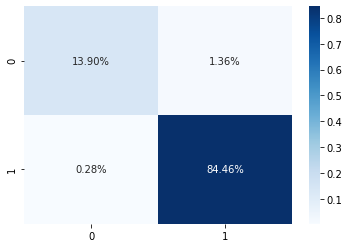

In [48]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_train, res)/np.sum(confusion_matrix(y_train, res)),annot=True,fmt='.2%', cmap='Blues')

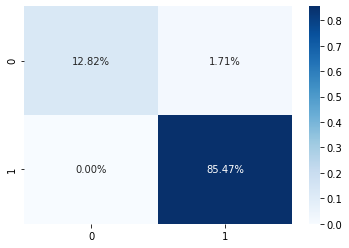

In [49]:
sns.heatmap(confusion_matrix(y_test, res_test)/np.sum(confusion_matrix(y_test, res_test)),annot=True,fmt='.2%', cmap='Blues')